# Maximum Likelihood as a linear regression problem


**Goal:** In this notebook you will learn how to calculate the maximum likelihood loss which is also the negative log likelihood, for an regression problem. You will define the negative log likelihood (NLL) loss function in Keras and use it to optimize the weights of a regression network. You will see that minimizing the NLL us the same as minimizing the mean squared error (MSE). You will learn that the optimal weights do not depend on $\sigma^2$  when you assume that the variance $\sigma^2$ is constant. In an second example you will try to minimize the NLL for 4 obervation pairs by changing $\mu$ and $\sigma^2$ with sliders and by using Tensorflow.

**Usage:** We recommend to read chapter 4.3 before working through this notebook. The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it. In addition you will find two exercises where you can do some experiments by yourself.

**Dataset:** For the first experiment, you work with the systolic blood pressure and age data of 33 American women. For the second experiment you work with four observed blood pressure values.

**Content:**

* First experiment on fitting a linear regression model
 * define the density function of a Normal distribution with constant variance.  
 * define a custom loss for the NLL
 * fit a linear regression model for the blood pressure data with the NLL loss 
 * see that the weights of the NN do not depend on $\sigma^2$ 


* Second experiment on fitting a Normal distribution
 * Plot a Normal distribution along with the likelihood of the observed values as shown in figure 4.17
 * Manually adapt the parameter values of the Normal distribution to achieve a maximal joint likelihood or minimal NLL 
 * use Tensorflow to optimize  $\mu$ and $\sigma^2$ automatically by minimizing the NLL


[open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_04/nb_ch04_03.ipynb)

#### Imports
In the next two cells, we load all the required libraries. 

In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0  
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  False


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation
from tensorflow.keras import optimizers

tf.__version__

'2.0.0-alpha0'

## Define a custom functions for the Normal densitiy and the NLL

Now let's define a function that calculates the density $f(y,\mu,\sigma)$ of a normal distribution at $y$, given the parameters $\mu$ and $\sigma$ using the formula:

$$
  f(y, \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(y - \mu)^2}{2 \sigma^2}}
$$

we will keep $\sigma$ to the fixed value 20.


In [3]:
def f(y, mu, sigma=20):
  return (1/(sigma * tf.math.sqrt(2 * np.pi)) * tf.math.exp( - (y - mu)**2 / (2 * sigma**2)))

In the next cell we want to use the functon to calculate the density of a normal distribution at the systolic blood pressure $y=131$, for a given $\mu=111$ and $\sigma=20$.
Compare the result with the Figure 4.13 in the book.

In [4]:
f(131, 111)

<tf.Tensor: id=8, shape=(), dtype=float32, numpy=0.012098536>

Text(0, 0.5, 'probability density')

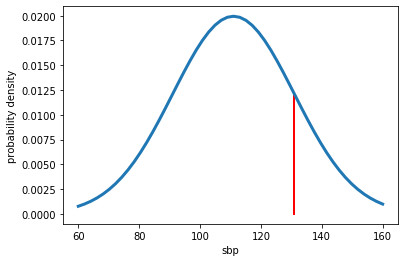

In [5]:
sbp = np.linspace(60,160,50, dtype='float32')
plt.plot([131, 131], [0, f(131,111)], 'k-', lw=2,color='red')
plt.plot(sbp, f(sbp, 111),linewidth=3)
plt.xlabel('sbp')
plt.ylabel('probability density')

## First experiment on fitting a linear regression model

Here we define the systolic blood pressure and the age of the 33 American women of our dataset

In [6]:
# Blood Pressure data
x = [22, 41, 52, 23, 41, 54, 24, 46, 56, 27, 47, 57, 28, 48, 58,  9, 
     49, 59, 30, 49, 63, 32, 50, 67, 33, 51, 71, 35, 51, 77, 40, 51, 81]
y = [131, 139, 128, 128, 171, 105, 116, 137, 145, 106, 111, 141, 114, 
     115, 153, 123, 133, 157, 117, 128, 155, 122, 183,
     176,  99, 130, 172, 121, 133, 178, 147, 144, 217] 
x = np.asarray(x, np.float32) 
y = np.asarray(y, np.float32)

Let's fit a simple linear regression to the systolic blood pressure of the 33 women. You can assume a constant variance and a mean that depends linearly on the age. Therefor you setup a NN without any hidden layer and only one output node for the mean of the CPD.  The NLL for this case is the MSE which is a standard loss function in Keras (recall chapter 3). You still use here the custom loss function for the NLL to check that it yields the same result as you got with the Keras MSE loss.


To create a custom loss function, you have to follow the interface 
 `loss(y_true, y_pred)`.
 
We define the loss as follows:
$
    l = -\sum_{i=1}^n \log (f(y_i, a \cdot x+b)) =  -\sum_{i=1}^n \log(f(y_i, ypred_i)) 
$

<div class="alert alert-warning">
Remove #A in line #2
</div>

In [7]:
# custom loss function
def my_loss(y_true,y_pred): #A
  loss = -tf.reduce_sum(tf.math.log(f(y_true,y_pred)))
  return loss

# setup NN w/o hidden layer and with output node
model = Sequential() 
model.add(Dense(1, activation='linear', 
                batch_input_shape=(None, 1)))
model.compile(loss=my_loss,optimizer="adam") # use custom loss


In [8]:
# fit the model and give out the two weights of the NN (slobe and intercept)
for i in range(0,120000):
    model.fit(x=x,y=y,batch_size=33,
                    epochs=1,
                    verbose = 0)
    a,b=model.get_weights()
    if i % 5000==0:
        mse=np.mean(np.square(model.predict(x).reshape(len(x),)-y))
        print("Epoch:",i,"slope=",a[0][0],"intercept=",b[0],"MSE=",mse)

#Should reach (you might need to do more iteration)
#1.   optimal value for slope: 1.1050216
#2.   optimal value for intercept: 87.67143
#3.   minimal MSE: 349.200787168560

Epoch: 0 slope= 0.2892248 intercept= 0.0009999998 MSE= 16224.9375
Epoch: 5000 slope= 2.72995 intercept= 3.0694587 MSE= 1143.349
Epoch: 10000 slope= 2.6608188 intercept= 6.9904428 MSE= 1071.368
Epoch: 15000 slope= 2.5653713 intercept= 11.915948 MSE= 985.8836
Epoch: 20000 slope= 2.4702191 intercept= 16.849976 MSE= 905.64886
Epoch: 25000 slope= 2.3751805 intercept= 21.780472 MSE= 830.86743
Epoch: 30000 slope= 2.2802598 intercept= 26.70273 MSE= 761.59143
Epoch: 35000 slope= 2.1854746 intercept= 31.62061 MSE= 697.7458
Epoch: 40000 slope= 2.0908616 intercept= 36.527897 MSE= 639.3868
Epoch: 45000 slope= 1.9963976 intercept= 41.429783 MSE= 586.4264
Epoch: 50000 slope= 1.9021391 intercept= 46.31908 MSE= 538.913
Epoch: 55000 slope= 1.8081241 intercept= 51.19734 MSE= 496.7931
Epoch: 60000 slope= 1.7144322 intercept= 56.057537 MSE= 460.08014
Epoch: 65000 slope= 1.6211797 intercept= 60.89499 MSE= 428.7436
Epoch: 70000 slope= 1.5284675 intercept= 65.70662 MSE= 402.725
Epoch: 75000 slope= 1.4366722 i

When we minimize the negativ log likelihood, the optimal values for the slope and intercept are the same as in chapter 3, where we minized the MSE!


### Exercise 1 
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  


*Exercise 1: Change the value of sigma in the calculation of the likelihood (function f) and rerun the cells. Does the result depend on it?*

Scroll down to see the solution.
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<div class="alert alert-warning">
No solution? Below is mine with random value of 500
</div>

In [9]:
# custom loss function
def my_loss(y_true,y_pred): #A
  loss = -tf.reduce_sum(tf.math.log(f(y_true,y_pred,500)))
  return loss

# setup NN w/o hidden layer and with output node
model = Sequential() 
model.add(Dense(1, activation='linear', 
                batch_input_shape=(None, 1)))
model.compile(loss=my_loss,optimizer="adam") # use custom loss


In [10]:
# fit the model and give out the two weights of the NN (slobe and intercept)
for i in range(0,120000):
    model.fit(x=x,y=y,batch_size=33,
                    epochs=1,
                    verbose = 0)
    a,b=model.get_weights()
    if i % 5000==0:
        mse=np.mean(np.square(model.predict(x).reshape(len(x),)-y))
        print("Epoch:",i,"slope=",a[0][0],"intercept=",b[0],"MSE=",mse)

#Should reach (you might need to do more iteration)
#1.   optimal value for slope: 1.1050216
#2.   optimal value for intercept: 87.67143
#3.   minimal MSE: 349.200787168560

Epoch: 0 slope= -0.6518318 intercept= 0.0009998581 MSE= 29627.719
Epoch: 5000 slope= 2.5744915 intercept= 3.4851332 MSE= 1191.7484
Epoch: 10000 slope= 2.6693537 intercept= 6.5763702 MSE= 1078.8019
Epoch: 15000 slope= 2.5742943 intercept= 11.455632 MSE= 993.64417
Epoch: 20000 slope= 2.4790943 intercept= 16.389769 MSE= 912.904
Epoch: 25000 slope= 2.384045 intercept= 21.320265 MSE= 837.6192
Epoch: 30000 slope= 2.289183 intercept= 26.24258 MSE= 767.8399
Epoch: 35000 slope= 2.1943555 intercept= 31.160606 MSE= 703.4902
Epoch: 40000 slope= 2.099775 intercept= 36.06737 MSE= 644.6362
Epoch: 45000 slope= 2.0053341 intercept= 40.969257 MSE= 591.175
Epoch: 50000 slope= 1.9110721 intercept= 45.859123 MSE= 543.1568
Epoch: 55000 slope= 1.8169626 intercept= 50.73815 MSE= 500.53278
Epoch: 60000 slope= 1.7232623 intercept= 55.599247 MSE= 463.31824
Epoch: 65000 slope= 1.6299917 intercept= 60.43779 MSE= 431.4831
Epoch: 70000 slope= 1.537239 intercept= 65.2506 MSE= 404.97043
Epoch: 75000 slope= 1.4454113 i

<div class="alert alert-warning">
Below sentence is missing a word 'depend', like so <br>
    No, the result does not depend on the value of the variance which is a assumed to be constant.
</div>

**Solution**

No, the result does not on the value of the variance which is a assumed to be constant.

### Return to the book 
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/Page_turn_icon_A.png" width="120" align="left" />  

## Second experiment on fitting a Normal distribution model

In the next cells you will assume that you observed the systolic blood pressure of 4 women of the same age:   sbp=[131,105,114,117].
Let's plot a normal distribution along with the likelihood of the observed values,
Your task is to manually adapt the parameters $\mu$ and $\sigma$ of the Normal distribution (with the interactive silders) that yield a maximal joint likelihood which you get with the same parameter values that yield a minimal NLL.



In [11]:
#!pip install ipywidgets

In [12]:
from ipywidgets import interactive
plt.figure(figsize=(5,5))
ys=np.array([131,105,114,117], dtype='float32')
sbp = np.linspace(80,140,200, dtype='float32')

def make_interactive(mu, sigma):
    likelihoods = f(ys, mu,sigma)
    for i in range(4):
        plt.plot([ys[i], ys[i]], [0, likelihoods[i]], 'k-', lw=1,color='red') 
    plt.plot(sbp, f(sbp, mu,sigma),linewidth=3)
    plt.xlabel('sbp')
    plt.ylabel('likelihood')
    plt.title('NLL: {:.2f}'.format(-np.sum(np.log(likelihoods))))

interactive(make_interactive,mu=(90, 130, 1), sigma=(2,20,1))

interactive(children=(IntSlider(value=110, description='mu', max=130, min=90), IntSlider(value=11, description…

<Figure size 360x360 with 0 Axes>

### Exercise 2
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  

Exercise 2: Use TF to fit a Normal distribution that minimizes the NLL for the systolic blood pressure of the 4 observed sbp values . Compare the results with your manually determined parameters $\mu$ and $\sigma$.

In [13]:
# Write your code here

Scroll down to see the solution.

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

<div class="alert alert-warning">
What do you mean below? Seems like a left over comment... and what you did previously, i.e. requiring specific version of TF works.</div>

**Note TODO After release of TF 2.0**

Needs some inverstigation. How to do this the TF2.0 way after the release.

In [14]:
mu     = tf.Variable(124.0)
sigma =  tf.Variable(10.0)
variables = [mu,sigma]
#eta = 0.0004
#likelihoods = f(ys, mu,sigma)
#loss = -tf.math.reduce_sum(tf.math.log(likelihoods)) 
optimizer = tf.optimizers.Adam()


In [15]:
# Gradient Decent with TF in eager modus:
for i in range(10000):
  with tf.GradientTape() as tape: #Record the gradients from now on
    likelihoods = f(ys, mu,sigma)
    loss = -tf.math.reduce_sum(tf.math.log(likelihoods))
    grads = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    #grad_mu, grad_sigma  = tape.gradient(loss, [mu,sigma])
    #mu = tf.Variable(mu - eta * grad_mu)
    #sigma = tf.Variable(sigma - eta * grad_sigma)

    if (i % 250 == 0):
      print("Epoch:",i, "mu=",mu.numpy(),"sigma=",sigma.numpy(), "NNL=", loss.numpy())

Epoch: 0 mu= 123.999 sigma= 10.001 NNL= 15.681095
Epoch: 250 mu= 123.75322 sigma= 10.235319 NNL= 15.580298
Epoch: 500 mu= 123.51592 sigma= 10.434735 NNL= 15.498945
Epoch: 750 mu= 123.28526 sigma= 10.599915 NNL= 15.4315815
Epoch: 1000 mu= 123.05974 sigma= 10.730648 NNL= 15.374268
Epoch: 1250 mu= 122.837746 sigma= 10.826036 NNL= 15.323982
Epoch: 1500 mu= 122.61827 sigma= 10.884986 NNL= 15.27849
Epoch: 1750 mu= 122.40066 sigma= 10.906953 NNL= 15.236139
Epoch: 2000 mu= 122.18322 sigma= 10.892846 NNL= 15.195527
Epoch: 2250 mu= 121.96578 sigma= 10.845757 NNL= 15.155945
Epoch: 2500 mu= 121.747444 sigma= 10.77124 NNL= 15.116928
Epoch: 2750 mu= 121.5281 sigma= 10.676418 NNL= 15.07843
Epoch: 3000 mu= 121.30838 sigma= 10.569158 NNL= 15.04069
Epoch: 3250 mu= 121.08713 sigma= 10.456282 NNL= 15.003695
Epoch: 3500 mu= 120.86592 sigma= 10.343265 NNL= 14.967867
Epoch: 3750 mu= 120.646576 sigma= 10.234176 NNL= 14.933611
Epoch: 4000 mu= 120.42786 sigma= 10.131305 NNL= 14.900812
Epoch: 4250 mu= 120.211075